In [11]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [88]:
df_for_etna = pd.read_csv('./df_for_etna.csv')
df_for_etna_week = pd.read_csv('./df_for_etna_week.csv')
df_for_etna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1825 non-null   object 
 1   target     1825 non-null   float64
 2   segment    1825 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 42.9+ KB


Одна серия

In [96]:
# df_one = df_for_etna[df_for_etna.segment == 3][['timestamp', 'target']]
# df_one['timestamp'] = pd.to_datetime(df_one['timestamp'])
# df_one = df_one.set_index('timestamp')

In [89]:
df_one = df_for_etna_week[df_for_etna_week.segment == 3][['timestamp', 'target']]
df_one['timestamp'] = pd.to_datetime(df_one['timestamp'])
df_one = df_one.set_index('timestamp')

In [90]:
# y = df_for_etna_week[df_for_etna_week.segment == 3]['target']
y = df_one['target']
# y_train, y_test = temporal_train_test_split(y, test_size=int(365*0.2))
y_train, y_test = temporal_train_test_split(y, test_size=1)

In [82]:
y_train.values

array([2645, 2127, 2238, 2116, 2342, 2471, 2699, 2711, 2830, 2941, 3448,
       2890, 2601, 2747, 2643, 2545, 2638, 2539, 2343, 2461, 2347, 2567,
       2675, 2717, 2526, 2447, 2502, 2757, 2655, 2380, 2257, 2316, 2261,
       2370, 2286, 2293, 2218, 2184, 2599, 2679, 2864, 2599, 2673, 2853,
       2648, 2623, 3007, 2784, 2975, 3178, 2989], dtype=int64)

In [91]:
model = ARIMA(y_train, order=(2,1,0))
model_fit = model.fit()

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)


In [92]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                   51
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -336.793
Date:                Sun, 26 Mar 2023   AIC                            679.585
Time:                        16:43:52   BIC                            685.321
Sample:                    01-01-1970   HQIC                           681.769
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2169      0.125     -1.736      0.083      -0.462       0.028
ar.L2         -0.1589      0.144     -1.105      0.269      -0.441       0.123
sigma2       4.18e+04   8051.727      5.191      0.0

In [93]:
mean_demand = y_train.mean()
variance_demand = y_train.var()
print(mean_demand, variance_demand)

2592.235294117647 76665.62352941177


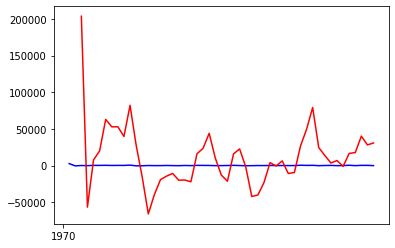

In [87]:
residuals = pd.DataFrame(model_fit.resid)
# Расчет усреднения остатков на основ
е оценок среднего значения спроса и его вариации
average_residuals = residuals.rolling(3).mean() * variance_demand**0.5 + mean_demand

# Построение графика остатков и усреднения
plt.plot(residuals, color='blue')
plt.plot(average_residuals, color='red')
plt.show()


In [78]:
np.mean(model_fit.resid), np.std(model_fit.resid)

(64.25107032608142, 450.9744596460574)

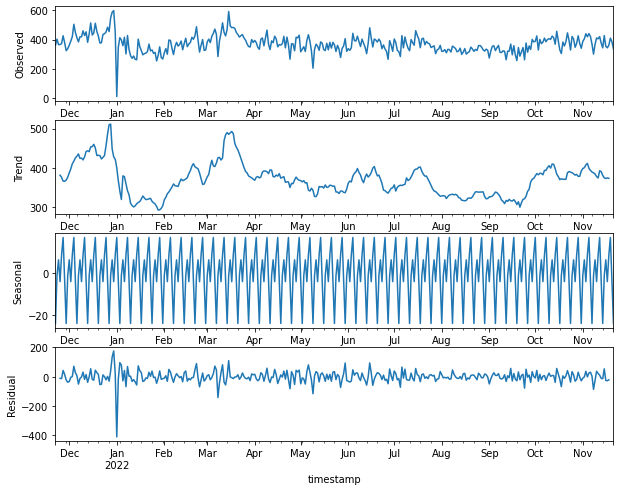

In [108]:
decomposition = sm.tsa.seasonal_decompose(df_one, model='additive')

# Plot the decomposed time series
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Remove the seasonal component from the original time series
deseasonalized_data = df_one['target'] - decomposition.seasonal

In [112]:
deseasonalized_data = deseasonalized_data - decomposition.trend.fillna(0)

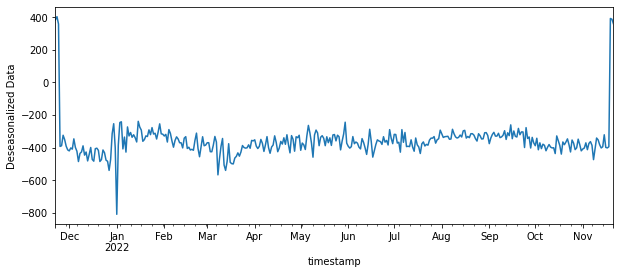

In [113]:
# Plot the deseasonalized time series
deseasonalized_data.plot(figsize=(10,4))
plt.ylabel('Deseasonalized Data')
plt.show()

In [114]:
deseasonalized_data

timestamp
2021-11-22    384.980007
2021-11-23    404.125666
2021-11-24    358.571044
2021-11-25   -393.150568
2021-11-26   -389.035183
                 ...    
2022-11-17   -402.436282
2022-11-18   -395.178040
2022-11-19    392.898775
2022-11-20    388.181688
2022-11-21    359.980007
Length: 365, dtype: float64

In [115]:
df_one['target']

timestamp
2021-11-22    361.0
2021-11-23    403.0
2021-11-24    365.0
2021-11-25    366.0
2021-11-26    372.0
              ...  
2022-11-17    343.0
2022-11-18    361.0
2022-11-19    410.0
2022-11-20    385.0
2022-11-21    336.0
Name: target, Length: 365, dtype: float64